<h1><center><font size="25">Forecasting with LSTM models</font></center></h1>

<center><b>Joaquín Amat Rodrigo, Javier Escobar Ortiz</b></center>

<center><i>September, 2023</i></center>

**More about forecasting**

+ [Introduction to forecasting with skforecast](https://cienciadedatos.net/documentos/py27-time-series-forecasting-python-scikitlearn.html)
+ [Forecasting time series with gradient boosting: Skforecast, XGBoost, LightGBM and CatBoost](https://www.cienciadedatos.net/documentos/py39-forecasting-time-series-with-skforecast-xgboost-lightgbm-catboost.html)
+ [Forecasting electricity demand with Python](https://www.cienciadedatos.net/documentos/py29-forecasting-electricity-power-demand-python.html)
+ [Forecasting web traffic with machine learning and Python](https://www.cienciadedatos.net/documentos/py37-forecasting-web-traffic-machine-learning.html)
+ [Bitcoin price prediction with Python, when the past does not repeat itself](https://www.cienciadedatos.net/documentos/py41-forecasting-cryptocurrency-bitcoin-machine-learning-python.html)
+ [Prediction intervals in forecasting models](https://www.cienciadedatos.net/documentos/py42-forecasting-prediction-intervals-machine-learning.html)
+ [Intermittent demand forecasting with skforecast](https://www.cienciadedatos.net/documentos/py48-intermittent-demand-forecasting)

<p align="center"><img src='https://github.com/JoaquinAmatRodrigo/skforecast/raw/master/docs/img/banner-landing-page-skforecast.png'style="width: 600px"></p>

## Introdución


<p align="center"><img src='lstm1.png'style="width: 600px"></p>

## Librerías

In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
sys.path.insert(1, str(Path.cwd().parent))
str(Path.cwd().parent)

'/Users/fernandocarazo/Documents/git-repos/skforecast'

In [2]:
#!pip install tensorflow

In [3]:
#!pip install torch -f https://download.pytorch.org/whl/torch_stable.html
#!pip install pytorch-forecasting

In [129]:
# Data processing
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Modelling
# ==============================================================================
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.ForecasterRnnTensorFlow import ForecasterRnnTensorFlow
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Dense, Input, Reshape, LSTM
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adagrad, Adadelta, Adamax, Nadam
from tensorflow.keras.losses import MeanSquaredError

from tensorflow.keras.callbacks import EarlyStopping


## Datos

In [5]:
# Downloading data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/Estadistica-machine-'
       'learning-python/master/data/bike_sharing_dataset_clean.csv')
data = pd.read_csv(url)
data['date_time'] = pd.to_datetime(data['date_time'], format='%Y-%m-%d %H:%M:%S')
data = data.set_index('date_time')
print(data.index.to_series().diff().dt.total_seconds().value_counts())
data = data.asfreq('H')
data = data.sort_index()
data = data.drop(columns=['workingday'])
data.head()

date_time
3600.0    17543
Name: count, dtype: int64


,holiday,weather,temp,atemp,hum,windspeed,users,month,hour,weekday
date_time,,,,,,,,,,
2011-01-01 00:00:00,0.0,clear,9.84,14.395,81.0,0.0,16.0,1,0,5
2011-01-01 01:00:00,0.0,clear,9.02,13.635,80.0,0.0,40.0,1,1,5
2011-01-01 02:00:00,0.0,clear,9.02,13.635,80.0,0.0,32.0,1,2,5
2011-01-01 03:00:00,0.0,clear,9.84,14.395,75.0,0.0,13.0,1,3,5
2011-01-01 04:00:00,0.0,clear,9.84,14.395,75.0,0.0,1.0,1,4,5


In [6]:
data.index.min(), data.index.max()

(Timestamp('2011-01-01 00:00:00'), Timestamp('2012-12-31 23:00:00'))

In [33]:
data = data.drop(columns=["weather"])

In [34]:
# Split train-validation-test
# ==============================================================================
end_train = '2012-03-31 23:59:00'
end_validation = '2012-08-31 23:59:00'
data_train = data.loc[: end_train, :]
data_val   = data.loc[end_train:end_validation, :]
data_test  = data.loc[end_validation:, :]

print(f"Dates train      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates validacion : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Dates test       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Dates train      : 2011-01-01 00:00:00 --- 2012-03-31 23:00:00  (n=10944)
Dates validacion : 2012-04-01 00:00:00 --- 2012-08-31 23:00:00  (n=3672)
Dates test       : 2012-09-01 00:00:00 --- 2012-12-31 23:00:00  (n=2928)


## Modelo LSTM con tensorflow-keras

https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

https://www.tensorflow.org/tutorials/structured_data/time_series


We are working with a univariate series, so the number of features is one, for one variable.

The number of time steps as input is the number of lags used as predictors.

We almost always have multiple samples, therefore, the model will expect the input component of training data to have the dimensions or shape: [samples, timesteps, features]

# Multi-series, multi-step

In [8]:
# def prepare_lstm_input(df, num_lags, num_steps, targets=None, scaler=MinMaxScaler()):
#     # Crear un DataFrame vacío para almacenar las columnas de lags
#     lag_df = pd.DataFrame()

#     df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
#     # Paso 1: Crear lags para todas las columnas
#     for col in df.columns:
#         for i in range(1, num_lags + 1):
#             lag_df[f'{col}_lag_{i}'] = df[col].shift(i)         
    
#     # lag_df = lag_df.dropna()

#     # Paso 3: Escalar los datos
#     # scaler = MinMaxScaler()
    
#     n_features = df.shape[1]

#     X_data = []
#     for i in range(n_features):
#         X_data.append(lag_df.iloc[:, (num_lags*i):(num_lags*(i+1))])
        
#     X_data = np.array(X_data)
#     X_data = np.transpose(X_data, (1,2,0))
    
#     i_nas_x = np.isnan(X)
        
#     # Prepare Y
#     y_df = pd.DataFrame()
    
#     if targets == None:
#         n_targets = 1
#         for col in df.columns:
#             for i in range(1, num_steps + 1):
#                 y_df[f'{col}_step_{i}'] = df[col].shift(-i)
    
#     else:
#         n_targets = len(targets)
#         for col in targets:
#             for i in range(1, num_steps + 1):
#                 y_df[f'{col}_step_{i}'] = df[col].shift(-i)

#     y_data = []
#     for i in range(n_targets):
#         y_data.append(y_df.iloc[:, (num_steps*i):(num_steps*(i+1))])
    
#     y_data = np.array(y_data)
#     y_data = np.transpose(y_data, (1,2,0))
    
    
#     # Remove NAs 
#     X_data = X_data[num_lags:-num_lags, :, :]
#     y_data = y_data[num_lags:-num_lags, :, :]
    
#     return X_data, y_data

# # Ejemplo de uso:

In [121]:
# Training and test matrices
# ==============================================================================

lags = 24
levels = ['users', "hum"]
steps = 5
transformer_scaler = MinMaxScaler()
forecaster = ForecasterRnnTensorFlow(
    regressor=LinearRegression(), 
    lags=lags, 
    steps=steps, 
    levels=levels, 
    transformer_series=MinMaxScaler()
)


In [122]:
X_train, y_train = forecaster.create_train_X_y(data_train)
X_val, y_val     = forecaster.create_train_X_y(data_val)
X_test, y_test   = forecaster.create_train_X_y(data_test)

print("X_train shape\n-------------")
display(X_train.shape)
print("y_train shape\n-------------")
display(y_train.shape)


X_train shape
-------------


(10896, 24, 9)

y_train shape
-------------


(10896, 5, 2)

In [126]:
n_lags = X_train.shape[1]
n_series = X_train.shape[2]

n_steps = y_train.shape[1]
n_outputs = y_train.shape[2]

# Define the input layer
input_layer = Input(shape=(lags, n_series))

# LSTM layer
x = LSTM(100, activation='relu')(input_layer)

# Dense layers
x = Dense(64, activation='relu')(x)
x = Dense(n_outputs * steps, activation='linear')(x)

# Reshape layer
output_layer = Reshape((steps, n_outputs))(x)

# Create the model
model = Model(inputs=input_layer, outputs=output_layer)

model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 24, 9)]           0         
                                                                 
 lstm_10 (LSTM)              (None, 100)               44000     
                                                                 
 dense_18 (Dense)            (None, 64)                6464      
                                                                 
 dense_19 (Dense)            (None, 10)                650       
                                                                 
 reshape_10 (Reshape)        (None, 5, 2)              0         
                                                                 
Total params: 51114 (199.66 KB)
Trainable params: 51114 (199.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [127]:
# ---------------------------------------------------------------------------- #
#                               Compile the model                              #
# ---------------------------------------------------------------------------- #

optim = Adam(learning_rate=0.01)
loosf = MeanSquaredError()
model.compile(optimizer=optim, loss=loosf,)

history = model.fit(
    X_train, 
    y_train, 
    validation_data=(X_val, y_val),
    epochs=100, 
    verbose=1, 
    batch_size=128,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/100
86/86 [==============================] - 7s 45ms/step - loss: 10.2620 - val_loss: 0.0569
Epoch 2/100
86/86 [==============================] - 3s 38ms/step - loss: 0.0237 - val_loss: 0.0451
Epoch 3/100
86/86 [==============================] - 3s 40ms/step - loss: 0.0209 - val_loss: 0.0408
Epoch 4/100
86/86 [==============================] - 3s 39ms/step - loss: 0.0190 - val_loss: 0.0354
Epoch 5/100
86/86 [==============================] - 4s 43ms/step - loss: 0.0177 - val_loss: 0.0335
Epoch 6/100
86/86 [==============================] - 4s 47ms/step - loss: 0.0173 - val_loss: 0.0411
Epoch 7/100
86/86 [==============================] - 4s 45ms/step - loss: 0.0146 - val_loss: 0.0272
Epoch 8/100
86/86 [==============================] - 4s 41ms/step - loss: 0.0124 - val_loss: 0.0256
Epoch 9/100
86/86 [==============================] - 4s 44ms/step - loss: 0.0112 - val_loss: 0.0249
Epoch 10/100
86/86 [==============================] - 4s 46ms/step - loss: 0.0108 - val_loss: 0.023

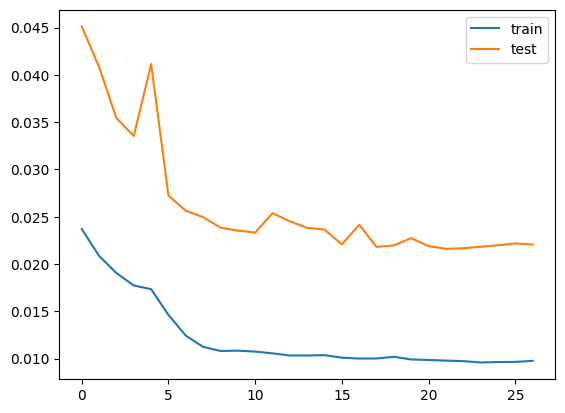

In [128]:
# plot history
def plot_history(history):
    plt.plot(history['loss'][1:], label='train')
    plt.plot(history['val_loss'][1:], label='test')
    plt.legend()
    plt.show()
    
plot_history(model.history.history)
    

Epoch 1/100


86/86 [==============================] - 3s 10ms/step - loss: nan - val_loss: nan
Epoch 2/100
86/86 [==============================] - 1s 7ms/step - loss: nan - val_loss: nan
Epoch 3/100
86/86 [==============================] - 0s 5ms/step - loss: nan - val_loss: nan
Epoch 4/100
86/86 [==============================] - 0s 6ms/step - loss: nan - val_loss: nan
Epoch 5/100
86/86 [==============================] - 0s 6ms/step - loss: nan - val_loss: nan


In [24]:

# Reshape from [samples, timesteps] into [samples, timesteps, features]
# ==============================================================================
def skforecast_X_train_to_lstm_exo_lags(X):
    """
    Transforms X_train matrix from skforecast format to LSTM format.

    Format rerquired by LSTM is [samples, timesteps, features]. For example,
    if X_train has 3 lags and 2 exogenous variables, lstm format will be:
    array([[[lag3, exog1, exog2],
            [lag2, exog1, exog2],
            [lag1, exog1, exog2]],
            ...,
            [[lag3, exog1, exog2],
            [lag2, exog1, exog2],
            [lag1, exog1, exog2]],
            ...,
        ])
            
    """
    exog_features = X.columns.str.split('_').str[0].unique().to_list()
    X_train_lstm = [X.filter(regex=f"^{x}") for x in exog_features]
    X_train_lstm = np.array(X_train_lstm)
    X_train_lstm =X_train_lstm.reshape(X_train_lstm.shape[1], X_train_lstm.shape[2], X_train_lstm.shape[0])
    return X_train_lstm
    

X_train = skforecast_X_train_to_lstm_exo_lags(X_train)
X_val   = skforecast_X_train_to_lstm_exo_lags(X_val)
X_test  = skforecast_X_train_to_lstm_exo_lags(X_test)
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape:   {X_val.shape}")
print(f"y_val shape:   {y_val.shape}")
print(f"X_test shape:  {X_test.shape}")
print(f"y_test shape:  {y_test.shape}")


# LSTM Multivariate multiple-step
# ==============================================================================
lr = 0.1

features = X_train.shape[2] # exog + y
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(steps, features), return_sequences=True))
model.add(LSTM(100, activation='relu',))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(steps, activation='linear'))
print(model.summary())

# optim = RMSprop(learning_rate=lr)
# optim = Adadelta(learning_rate=lr, rho=0.95, epsilon=1e-07, centered=False)
optim = Adam(learning_rate=lr)
loosf = MeanSquaredError()

model.compile(optimizer=optim, loss=loosf,)


X_train shape: (10943, 1, 3)
y_train shape: (10943, 1)
X_val shape:   (3671, 1, 3)


AttributeError: 'dict' object has no attribute 'shape'

Epoch 1/100
86/86 [==============================] - 10s 57ms/step - loss: 3712285.2500 - val_loss: 0.5796
Epoch 2/100
86/86 [==============================] - 3s 40ms/step - loss: 0.3728 - val_loss: 0.5588
Epoch 3/100
86/86 [==============================] - 3s 37ms/step - loss: 0.3528 - val_loss: 0.5332
Epoch 4/100
86/86 [==============================] - 3s 38ms/step - loss: 0.3302 - val_loss: 0.5056
Epoch 5/100
86/86 [==============================] - 3s 38ms/step - loss: 0.3068 - val_loss: 0.4772
Epoch 6/100
86/86 [==============================] - 4s 50ms/step - loss: 0.2835 - val_loss: 0.4493
Epoch 7/100
86/86 [==============================] - 6s 67ms/step - loss: 0.2613 - val_loss: 0.4226
Epoch 8/100
86/86 [==============================] - 8s 90ms/step - loss: 0.2405 - val_loss: 0.3974
Epoch 9/100
86/86 [==============================] - 8s 91ms/step - loss: 0.2215 - val_loss: 0.3740
Epoch 10/100
86/86 [==============================] - 6s 74ms/step - loss: 0.2042 - val_loss:

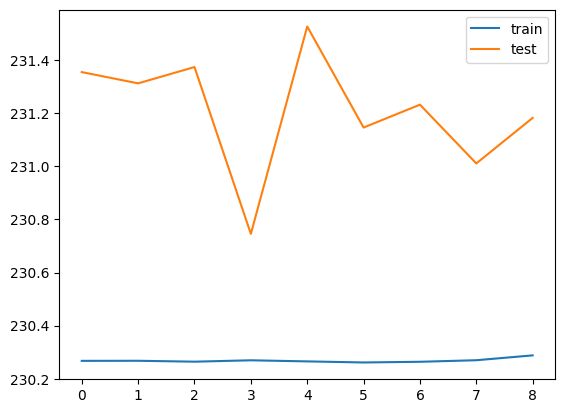

In [158]:
model.evaluate(X_test, y_test)

91/91 [==============================] - 1s 5ms/step - loss: 0.0578


0.05784473195672035

In [213]:
import sklearn
sklearn.__version__

'1.2.2'

In [228]:
# Predictions
# ==============================================================================
from sklearn import set_config
set_config(transform_output="pandas")

predictions = model.predict(X_test, verbose=0)
# predictions = predictions.flatten()
predictions.shape
# predictions = pd.Series(predictions, index=data_test.index[lags:len(predictions)+lags])
predictions = pd.DataFrame(
    predictions, 
    columns=y_test.columns,
    index=y_test.index)
predictions

# transform
# ==============================================================================
tt = MinMaxScaler()
tt.fit(data_test[['users']])
predictions = tt.inverse_transform(predictions, )
predictions = pd.DataFrame(predictions, columns=y_test.columns, index=y_test.index)
display(predictions.head())
display(data_test.head())

,y_step_1,y_step_2,y_step_3,y_step_4,y_step_5,y_step_6,y_step_7,y_step_8,y_step_9,y_step_10
date_time,,,,,,,,,,
2012-09-01 19:00:00,150.129181,150.17749,150.87854,150.491714,150.453735,149.669617,149.53801,150.337128,150.369156,150.376282
2012-09-01 20:00:00,150.129181,150.17749,150.87854,150.491714,150.453735,149.669617,149.53801,150.337128,150.369156,150.376282
2012-09-01 21:00:00,150.129181,150.17749,150.87854,150.491714,150.453735,149.669617,149.53801,150.337128,150.369156,150.376282
2012-09-01 22:00:00,150.129181,150.17749,150.87854,150.491714,150.453735,149.669617,149.53801,150.337128,150.369156,150.376282
2012-09-01 23:00:00,150.129181,150.17749,150.87854,150.491714,150.453735,149.669617,149.53801,150.337128,150.369156,150.376282


,holiday,weather,temp,atemp,hum,windspeed,users,month,hour,weekday
date_time,,,,,,,,,,
2012-09-01 00:00:00,0.0,clear,30.34,34.090,62.0,7.0015,168.0,9,0,5
2012-09-01 01:00:00,0.0,clear,29.52,34.850,74.0,8.9981,79.0,9,1,5
2012-09-01 02:00:00,0.0,clear,28.70,32.575,70.0,11.0014,69.0,9,2,5
2012-09-01 03:00:00,0.0,clear,28.70,32.575,70.0,7.0015,35.0,9,3,5
2012-09-01 04:00:00,0.0,clear,28.70,32.575,70.0,0.0000,12.0,9,4,5


In [231]:
predictions.max()

y_step_1     150.129181
y_step_2     150.177490
y_step_3     150.878540
y_step_4     150.491714
y_step_5     150.453735
y_step_6     149.669617
y_step_7     149.538010
y_step_8     150.337128
y_step_9     150.369156
y_step_10    150.376282
dtype: float32

In [118]:
# Prediction error (mean absolute error) sklearn
# ==============================================================================
mae = mean_absolute_error(data_test.loc[predictions.index, 'users'], predictions)
print(f"Test MAE: {mae}")

Test MAE: 51.722941591057


In [205]:
predictions

array([[0.1527963 , 0.15284579, 0.15356408, ..., 0.15300936, 0.15304217,
        0.15304947],
       [0.1527963 , 0.15284579, 0.15356408, ..., 0.15300936, 0.15304217,
        0.15304947],
       [0.1527963 , 0.15284579, 0.15356408, ..., 0.15300936, 0.15304217,
        0.15304947],
       ...,
       [0.1527963 , 0.15284579, 0.15356408, ..., 0.15300936, 0.15304217,
        0.15304947],
       [0.1527963 , 0.15284579, 0.15356408, ..., 0.15300936, 0.15304217,
        0.15304947],
       [0.1527963 , 0.15284579, 0.15356408, ..., 0.15300936, 0.15304217,
        0.15304947]], dtype=float32)

## Información de sesión

In [ ]:
import session_info
session_info.show(html=False)

-----
keras               2.13.1
matplotlib          3.7.1
numpy               1.24.3
pandas              1.5.3
session_info        1.0.0
skforecast          0.8.1
sklearn             1.3.0
tensorflow          2.13.0
-----
IPython             8.12.0
jupyter_client      8.1.0
jupyter_core        5.3.0
-----
Python 3.10.10 | packaged by Anaconda, Inc. | (main, Mar 21 2023, 18:39:17) [MSC v.1916 64 bit (AMD64)]
Windows-10-10.0.19045-SP0
-----
Session information updated at 2023-08-30 22:01


## Bibliografía
<br>

Linear Models with R by Julian J.Faraway [libro](https://www.amazon.es/gp/product/1439887330/ref=as_li_qf_asin_il_tl?ie=UTF8&tag=cienciadedato-21&creative=24630&linkCode=as2&creativeASIN=1439887330&linkId=e9ca62e854567fb3f9d0ea044f084b11)

OpenIntro Statistics: Fourth Edition by David Diez, Mine Çetinkaya-Rundel, Christopher Barr [libro](https://www.amazon.es/gp/product/1943450072/ref=as_li_qf_asin_il_tl?ie=UTF8&tag=cienciadedato-21&creative=24630&linkCode=as2&creativeASIN=1943450072&linkId=a8b49fab17a559d33901ee804a9b5737)

Introduction to Machine Learning with Python: A Guide for Data Scientists [libro](https://www.amazon.es/gp/product/1449369413/ref=as_li_qf_asin_il_tl?ie=UTF8&tag=cienciadedato-21&creative=24630&linkCode=as2&creativeASIN=1449369413&linkId=e07f892d9e2c458e8144303901ea9580)

Points of Significance: Association, correlation and causation. Naomi Altman & Martin Krzywinski Nature Methods

https://en.wikipedia.org/wiki/Co



In [ ]:
%%html
<style>
.text_cell_render p {
    text-align: justify;
    font-family: 'Open Sans','Helvetica Neue',Helvetica,Arial,sans-serif;
    line-height: 1.5;
    font-weight: 400;
    text-shadow: none;
    color: #333333;
    text-rendering: optimizeLegibility;
    letter-spacing: +0.1px;
    margin-bottom: 1.15rem;
    font-size: 1.15em
}

div.admonition.note {
    text-align: justify;
    font-family: 'Open Sans','Helvetica Neue',Helvetica,Arial,sans-serif;
    line-height: 1.5;
    font-weight: 400;
    text-shadow: none;
    color: #333333;
    text-rendering: optimizeLegibility;
    letter-spacing: +0.1px;
    margin-bottom: 1.15rem;
    font-size: 15px;
}


#notebook-container {
    background-color: #fcfcfc;
}

div.inner_cell {
    margin-right: 5%;
}

.output_png {
        display: table-cell;
        text-align: center;
        vertical-align: middle;
}

.rendered_html code {
    background-color: #f2f2f2;
    font-family: monospace;
    color: #a20505;
    font-size: 15px;
    padding: 1px 1px;
    border: solid;
    border-color: darkgray;
    border-width: thin;
}

.rendered_html h1 {
    padding-top: 50px;
}

.rendered_html h2 {
    font-size: 30px;
    margin-top: 0;
    font-size: 2.488em;
}

.rendered_html h3 {
    font-size: 25px;
}

.rendered_html h4 {
    font-size: 20px;
}

</style>

**¿Cómo citar este documento?**

<p style="text-align:left"><font size="3" color="#555">
TITULO DEL DOCUMENTO by AUTOR, available under a Attribution 4.0 International (CC BY 4.0) at https://www.cienciadedatos.net/documentos/pystats05-correlacion-lineal-python.html

    
</font></p>

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons Licence" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br />This work by AUTOR is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.